Importing the Libraries

In [1]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.layers import LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importing the dataset

In [4]:
sentiment_labels = pd.read_csv("sentiment_labels.txt", delimiter="|", quoting=3)
sentiment_labels.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [5]:
sentiment_labels['sentiment values'].count()

239232

In [6]:
dictionary = pd.read_csv("dictionary.txt", delimiter="|", quoting=3, header=None)
dictionary.columns = ['phrase', 'phrase ids']
dictionary.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


Merging the dictionary of phrases with its sentiment values

In [8]:
dataset = pd.merge(dictionary, sentiment_labels, how='left', on=['phrase ids'])
dataset.head()

,phrase,phrase ids,sentiment values
0,!,0,0.50000
1,! ',22935,0.52778
2,! '',18235,0.50000
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111


Cleaning the text

In [9]:
corpus = []
for i in range (0,239232):
  string = dataset['phrase'][i]
  review = string.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

Splitting the data using 95% of the data for training and 5% for testing

In [10]:
from sklearn.model_selection import train_test_split
sentence_train, sentence_test, y_train, y_test = train_test_split(corpus, dataset.iloc[:,-1].values, test_size=0.05)

Vectorize the text corpus into a list of integers

In [11]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)
X_train = tokenizer.texts_to_sequences(sentence_train)
X_test = tokenizer.texts_to_sequences(sentence_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(sentence_train[2])
print(X_train[2])

12835
funni sequenc
[29, 405]


Pad zeros with Keras to get vectors of equal length

In [12]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
print(X_train[60, :])

[1937  494    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


Build the model

In [15]:
opt = Adam(lr=0.0003, decay=0.0003/10)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=30, input_length=maxlen))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 30)            385050    
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 64)            5824      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 587,739
Trainable params: 587,739
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=100)

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
print(X_test[25], y_pred[25])
print(y_test[25])

Read the test dataset that was generated using webscraping

In [20]:
test = pd.read_csv("/content/test (1).csv")
test['Reviews'].count()

100

Cleaning the test data

In [21]:
corpus = []
for i in range (0,100):
  string = test['Reviews'][i]
  review = string.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

Vectorize the test data

In [22]:
test_data = tokenizer.texts_to_sequences(corpus)
test_data = pad_sequences(test_data, padding='post', maxlen=maxlen)

Predicting the sentiment value for the test data

In [23]:
y_pred_test = model.predict(test_data)

In [ ]:
print(y_pred_test)

Saving the sentiment values as a csv file

In [27]:
y_pred_test = y_pred_test.flatten()
test['sentiment values'] = y_pred_test
test.to_csv("Submission.csv")

Visualizing the results

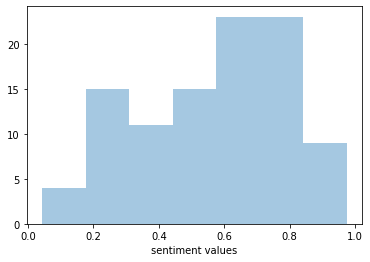

In [28]:
import seaborn as sns
sns.distplot(test['sentiment values'], kde=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


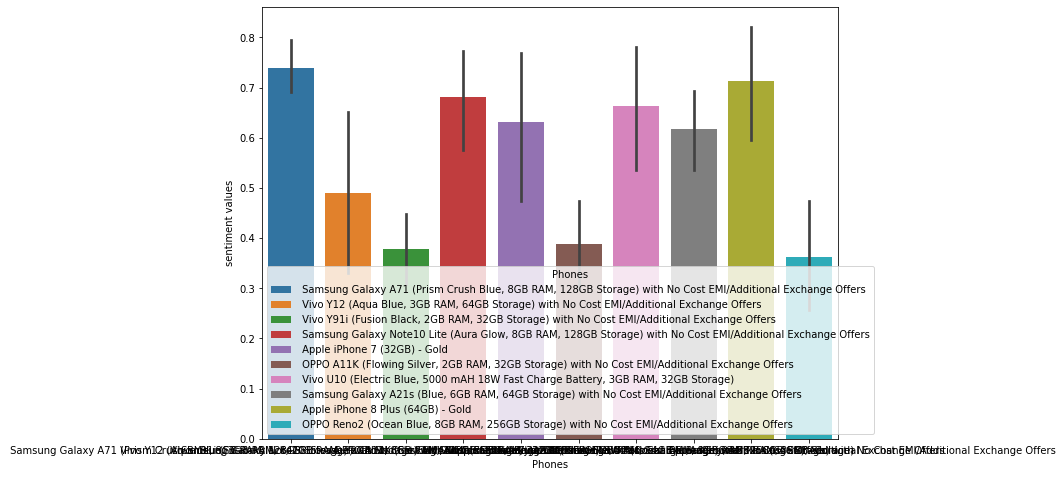

In [33]:
import matplotlib.pyplot as plt
f= plt.figure(figsize=(8, 6))
ax = f.add_axes([0,0,1,1])
sns.barplot(data=test, x='Phones', y='sentiment values', hue='Phones', dodge=False, ax=ax)
plt.tight_layout()
f.savefig('results.jpeg')

Vivo U10 seems to have the positive review with the highest sentiment value. Whereas OPPO Reno2 seems to have the most reviews with the lowest value.

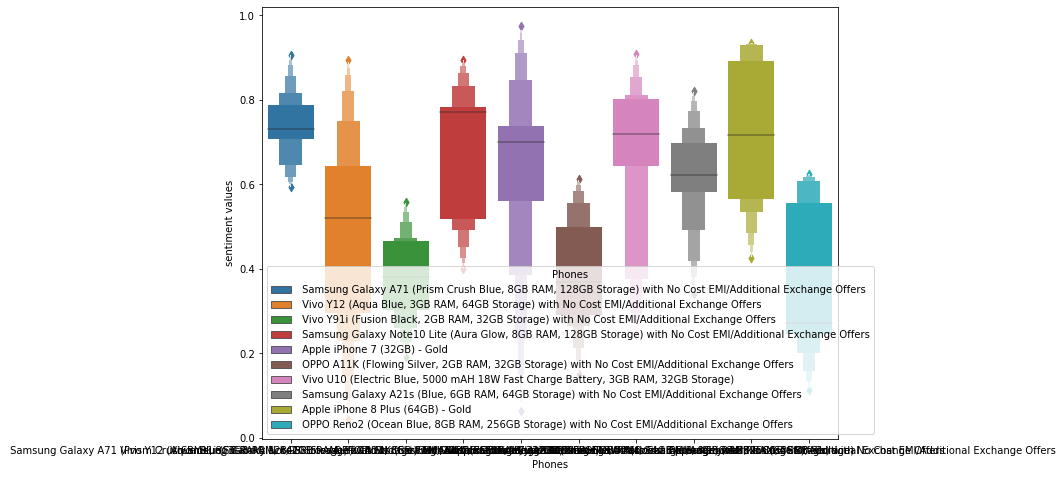

In [53]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
sns.boxenplot(x="Phones", y="sentiment values", data=test, ax=ax, hue='Phones', dodge=False)
fig.savefig("Boxenplot.jpeg")

From the boxen plot you can make out that Apple iPhone 8 Plus has the most number of positive reviews. Vivo Y12 has the most neutral reviews. OPPO Reno2 has the most number of negative reviews.